In [1]:
import numpy as np
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV ,StratifiedKFold

import numpy as np
import pylab as plt
from glob import glob
import argparse
import os
import progressbar
import pickle as pkl
from numpy.lib import stride_tricks
from skimage import feature
from sklearn import metrics
from sklearn.model_selection import train_test_split
import time
import mahotas as mt

import tensorflow as tf
from datetime import datetime
from IPython import display
from tensorflow.keras.utils import Sequence
from keras import backend as K
import random
import cv2

import math

import multiprocessing

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Reading data

In [3]:
def read_data(img_npy ,image_dir ,label_npy ,label_dir):
    print ('[INFO] Reading image data.')
    image_list = []
    label_list = []
    
    '''for file in img_npy:        
        for batch in range( bs1 ):        
            for row in range( train_ds[batch][0][...].shape[0] ):
                print('.' , row , end='')
        
                x = os.path.join( image_dir ,file )
                x = np.load( x )
                image_list.append( x )'''
                          
    for file in img_npy:
        x1 = os.path.join( image_dir ,file )
        #print(x1)
        x2 = np.load( x1 )        
        x2 = np.int64(x2*255)
        bs1 = len(x2)
        
        for batch in range( bs1 ):        
            x3 = x2[batch]            
            image_list.append( x3 )                
            if (batch == 1) & (file == "image_file_24.npy"):
                print("trainshape: " ,x3.shape)  
                
    for file in label_npy:
        x1 = os.path.join( label_dir ,file )
        #print(x1)
        x2 = np.load( x1 )    
        x2 = np.int64(x2*255)
        bs1 = len(x2)
        
        for batch in range( bs1 ):         
            x3 = x2[batch]         
            label_list.append( x3 )
            if (batch == 1) & (file == "label_file_24.npy"):
                print("trainshape: " ,x3.shape)

    return image_list, label_list

# Feature generation

In [6]:
def subsample(features, labels, low, high, sample_size):

    idx = np.random.randint(low, high, sample_size)

    return features[idx], labels[idx]

def subsample_idx(low, high, sample_size):

    return np.random.randint(low,high,sample_size)

In [7]:
def calc_haralick(roi):

    feature_vec = []

    texture_features = mt.features.haralick(roi)
    mean_ht = texture_features.mean(axis=0)

    [feature_vec.append(i) for i in mean_ht[0:9]]

    return np.array(feature_vec)

In [8]:
def harlick_features(img, h_neigh, ss_idx):

    print ('[INFO] Computing haralick features.')
    size = h_neigh
    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    strides = 2 * img.strides
    patches = stride_tricks.as_strided(img, shape=shape, strides=strides)
    patches = patches.reshape(-1, size, size)

    if len(ss_idx) == 0 :
        bar = progressbar.ProgressBar(maxval=len(patches), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    else:
        bar = progressbar.ProgressBar(maxval=len(ss_idx), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    bar.start()

    h_features = []

    if len(ss_idx) == 0:
        for i, p in enumerate(patches):
            bar.update(i+1)
            h_features.append(calc_haralick(p))
    else:
        for i, p in enumerate(patches[ss_idx]):
            bar.update(i+1)
            h_features.append(calc_haralick(p))

    return np.array(h_features)

In [9]:
def create_binary_pattern(img, p, r):

    print ('[INFO] Computing local binary pattern features.')
    lbp = feature.local_binary_pattern(img, p, r)
    return (lbp-np.min(lbp))/(np.max(lbp)-np.min(lbp)) * 255

In [10]:
def create_features(img, img_gray, label, train=True):

    lbp_radius = 24 # local binary pattern neighbourhood
    h_neigh = 11 # haralick neighbourhood
    num_examples = 1000
    lbp_points = lbp_radius*8
    h_ind = int((h_neigh - 1)/ 2)

    feature_img = np.zeros((img.shape[0],img.shape[1],4))
    feature_img[:,:,:3] = img
    img = None
    feature_img[:,:,3] = create_binary_pattern(img_gray, lbp_points, lbp_radius)
    feature_img = feature_img[h_ind:-h_ind, h_ind:-h_ind]
    features = feature_img.reshape(feature_img.shape[0]*feature_img.shape[1], feature_img.shape[2])

    if train == True:
        ss_idx = subsample_idx(0, features.shape[0], num_examples)
        features = features[ss_idx]
    else:
        ss_idx = []

    h_features = harlick_features(img_gray, h_neigh, ss_idx)
    features = np.hstack((features, h_features))

    if train == True:

        label = label[h_ind:-h_ind, h_ind:-h_ind]
        labels = label.reshape(label.shape[0]*label.shape[1], 1)
        labels = labels[ss_idx]
    else:
        labels = None

    return features, labels

In [11]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Executing feature generation

In [12]:
def create_training_dataset(image_list, label_list):

    print ('[INFO] Creating training dataset on %d image(s).' %len(image_list))

    X = []
    y = []

    x = len(image_list)
    for i in range(x):
        img_gray = np.int64( rgb2gray(image_list[i])  )
        features, labels = create_features(image_list[i], img_gray, label_list[i])
        X.append(features)
        y.append(labels)

    X = np.array(X)
    X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
    y = np.array(y)
    y = y.reshape(y.shape[0]*y.shape[1], y.shape[2]).ravel()

    print ('[INFO] Feature vector size:', X.shape)

    return X, y

# Training and Testing model

In [13]:
def train_model(X, y, classifier):

    if classifier == "SVM":
        from sklearn.svm import SVC
        print ('[INFO] Training Support Vector Machine model.')
        model = SVC()
        model.fit(X, y)
    elif classifier == "RF":
        from sklearn.ensemble import RandomForestClassifier
        print ('[INFO] Training Random Forest model.')
        model = RandomForestClassifier(n_estimators=250, max_depth=12, random_state=42)
        model.fit(X, y)
    elif classifier == "GBC":
        from sklearn.ensemble import GradientBoostingClassifier
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
        model.fit(X, y)

    print ('[INFO] Model training complete.')
    print ('[INFO] Training Accuracy: %.2f' %model.score(X, y))
    return model

In [14]:
def test_model(X, y, model):

    pred = model.predict(X)
    precision = metrics.precision_score(y, pred, average='weighted', labels=np.unique(pred))
    recall = metrics.recall_score(y, pred, average='weighted', labels=np.unique(pred))
    f1 = metrics.f1_score(y, pred, average='weighted', labels=np.unique(pred))
    accuracy = metrics.accuracy_score(y, pred)
    iou_score = metrics.jaccard_score(y, pred )

    print ('--------------------------------')
    print ('[RESULTS] Accuracy: %.2f' %iou_score)
    print ('[RESULTS] Accuracy: %.2f' %accuracy)
    print ('[RESULTS] Precision: %.2f' %precision)
    print ('[RESULTS] Recall: %.2f' %recall)
    print ('[RESULTS] F1: %.2f' %f1)
    print ('--------------------------------')

# Main body

In [15]:
def main(image_dir, label_dir, classifier, output_model):

    start = time.time()
    
    out_train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train'
    out_val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/val'

    # ====================
    # train set
    # ====================
    train_imgs = [s for s in sorted(os.listdir(out_train_data_dir + "/images/")) if s.endswith('.npy')]
    train_masks = [s for s in sorted(os.listdir(out_train_data_dir + "/masks/")) if s.endswith('.npy')]

    # ====================
    # validation set
    # ====================
    val_imgs = [s for s in sorted(os.listdir(out_val_data_dir + "/images/")) if s.endswith('.npy')]
    val_masks = [s for s in sorted(os.listdir(out_val_data_dir + "/masks/")) if s.endswith('.npy')]

    image_list , label_list = read_data( train_imgs
                                    , out_train_data_dir + "/images/"
                                    , train_masks
                                    , out_train_data_dir + "/masks/"
                                   )
    
    #images = []
    #labels = []
    '''for i in range(0, len(val_image_list)): 
        image_list.append(val_image_list[i])
        label_list.append(val_label_list[i])'''
    
    X_train, y_train = create_training_dataset(image_list, label_list)    
    
    model = train_model(X_train, y_train, classifier)
    #pkl.dump(model, open(output_model, "wb"))
    
    val_image_list , val_label_list = read_data( val_imgs
                                            , out_val_data_dir + "/images/"
                                            , val_masks
                                            , out_val_data_dir + "/masks/"
                                           )
    
    X_test, y_test = create_training_dataset(val_image_list, val_label_list)
    
    test_model(X_test, y_test, model)
    print ('Processing time:',time.time()-start)

In [ ]:
if __name__ == "__main__":
    image_dir =  None
    label_dir = None
    classifier = "RF"
    output_model = "/home/hgamarro/DeepLearning/JB_space/models/randomforest/randomforest1.pkl"
    main(image_dir, label_dir, classifier, output_model)

# Plotting Predictions

In [17]:
def create_features2(img):
    img_gray = np.int64( rgb2gray(img)  )

    features, _ = create_features(img, img_gray, label=None, train=False)

    return features

In [18]:
with open("/home/hgamarro/DeepLearning/JB_space/models/randomforest/randomforest1.pkl", 'rb') as f:
    model_trained = pkl.load(f)

In [19]:
border = 5 # (haralick neighbourhood - 1) / 2
img2 = val_image_list[10]
img = cv2.copyMakeBorder(img2, top=border, bottom=border, \
                              left=border, right=border, \
                              borderType = cv2.BORDER_CONSTANT, \
                              value=[0, 0, 0])

features = create_features2(img)
predictions = model_trained.predict(features.reshape(-1, features.shape[1]))
pred_size = int(math.sqrt(features.shape[0]))
inference_img = predictions.reshape(pred_size, pred_size)

[INFO] Computing local binary pattern features.


[INFO] Computing haralick features.


## Input image

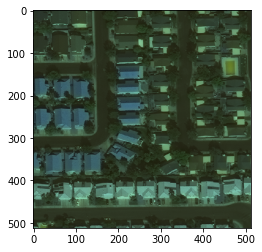

In [17]:
plt.imshow(val_image_list[10])

## Ground truth

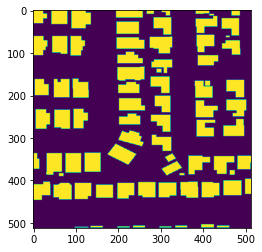

In [20]:
plt.imshow(val_label_list[10])

## Prediction with 1000 trees

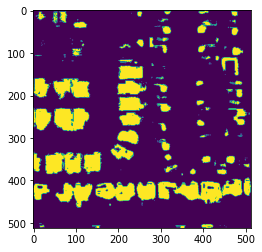

In [18]:
plt.imshow(inference_img)

## Prediction with 2000 trees (almost indiscernable difference)

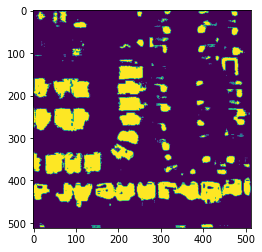

In [20]:
plt.imshow(inference_img)